In [7]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from problem import Problem
from data import DataGen
from models import * 

import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2

def generate_samples(n_samples, means, rho): 
    noises = torch.randn(n_samples, means.shape[0]) * rho
    return (torch.tensor(means) * ( 1 + noises)).detach().numpy()

def eval_model(forecast, X_test, Y_test, n_samples = 10):
    all_costs = [] 
    all_decisions = []

    saa_rho = 0.1
    saa_n_samples = n_samples

    if n_samples == 0: 
        saa_rho = 0 
        saa_n_samples = 1

    t = 0
    for x,d in zip(X_test, Y_test): 
        if t > 300: break
        t += 1

        pred = forecast(x.unsqueeze(0))
        samples = generate_samples(saa_n_samples, pred, saa_rho)
        decision, _ = saa(samples, H, B, cross_costs, test=False) 
        # print(decision, samples)
        _, cost = saa(d.unsqueeze(0).detach().numpy(), H, B, cross_costs, decision[0].detach().numpy(), test=True)
        all_costs.append(cost)
        print(t, " ", np.mean(all_costs))
        all_decisions.append(decision[0].numpy())
    all_decisions = np.array(all_decisions)
    all_decisions = torch.tensor(all_decisions) 
    return all_costs, all_decisions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
np.random.seed(0)
torch.manual_seed(0)

# make random distances
n_nodes = 2
n_features = 1

H = torch.tensor([1 for i in range(n_nodes)])
B = torch.tensor([5 for i in range(n_nodes)])  

problem_ = Problem(H, B, n_nodes)
# cross_costs = problem_.cross_costs

c = 5
cross_costs = np.array([[c, 0], [0, c]])
problem_.set_cross_costs(cross_costs)

n_data = 100
n_test = 1000
data_generator = DataGen(n_features, n_nodes)
X_train, Y_train, X_test, Y_test = data_generator.get_test_train(n_data, n_test)

c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\data.py:33: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = 0.5 + y + 0.1 * torch.from_numpy(np.random.multivariate_normal([0,0], [[1,0.1],[-0.1,1]], len(y)))


In [278]:
print("Train Two-Stage -------------------------------------")
two_stage_forecast = train_two_stage(problem_, X_train, Y_train, X_test, Y_test, EPOCHS=1000)

Train Two-Stage -------------------------------------
epoch  0 test cost:  1.7860945835190396 train cost:  1.8592354468241092
epoch  10 test cost:  2.166570409631593 train cost:  2.2627864774673934
epoch  20 test cost:  2.333197884898869 train cost:  2.4399234381489214
epoch  30 test cost:  2.3452928572020064 train cost:  2.4302895775981006
epoch  40 

c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\models.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(YY[i:i+batch_size:]).float()
c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\models.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X_train[i:i+batch_size,:]).float()


test cost:  2.329175618199868 train cost:  2.3983933681979535
epoch  50 test cost:  2.3143496541234234 train cost:  2.3756746756270286
epoch  60 test cost:  2.299213326843692 train cost:  2.354483827574527
epoch  70 test cost:  2.28428813080327 train cost:  2.3344807281329985
epoch  80 test cost:  2.2692527267544103 train cost:  2.3159023261800167
epoch  90 test cost:  2.2449546872938555 train cost:  2.2845285686835406
epoch  100 test cost:  2.200024221670119 train cost:  2.2161815389975663
epoch  110 test cost:  2.1660322256500404 train cost:  2.1687449663117286
epoch  120 test cost:  2.1401851140803227 train cost:  2.1396907336249704
epoch  130 test cost:  2.1154541187009346 train cost:  2.1151204998031017
epoch  140 test cost:  2.0777618749926368 train cost:  2.077112104500061
epoch  150 test cost:  2.03827635279694 train cost:  2.039207266958779
epoch  160 test cost:  1.9623704828436057 train cost:  1.9527429409496244
epoch  170 test cost:  1.8535067342130969 train cost:  1.8393593

In [279]:
print("Train end-to-end -------------------------------------")
task_forecast = train_task_loss(problem_, X_train, Y_train, X_test, Y_test, two_stage_forecast, EPOCHS=2000)

Train end-to-end -------------------------------------
epoch: 0
Cost:  0.4798992
epoch  0 test cost:  0.4896288267264643 train cost:  0.47903225663897964
epoch: 1
Cost:  0.47930655
epoch  1 test cost:  0.48859719574847604 train cost:  0.4778490639090297
epoch: 2
Cost:  0.47871467
epoch  2 test cost:  0.4875762369746843 train cost:  0.47670386705396145
epoch: 3
Cost:  0.47813302
epoch  3 test cost:  0.48656404468813325 train cost:  0.4755838138222453
epoch: 4
Cost:  0.47756028
epoch  4 test cost:  0.4855637303555885 train cost:  0.47446761179563973
epoch: 5
Cost:  0.47699258
epoch  5 test cost:  0.4845709378572681 train cost:  0.47335363197920294
epoch: 6
Cost:  0.476428
epoch  6 test cost:  0.48358377447747974 train cost:  0.47224107686278793
epoch: 7
Cost:  0.47586557
epoch  7 test cost:  0.4825986441115418 train cost:  0.4711294488966224
epoch: 8
Cost:  0.47530466
epoch  8 test cost:  0.48162011164077906 train cost:  0.4700511809050796
epoch: 9
Cost:  0.4747483
epoch  9 test cost:  0

c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\models.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(YY[i:i+batch_size:]).float()
c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\models.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X_train[i:i+batch_size,:]).float()


epoch  27 test cost:  0.4655552624056616 train cost:  0.45349549572763415
epoch: 28
Cost:  0.46554065
epoch  28 test cost:  0.4647978250200429 train cost:  0.4526969863086698
epoch: 29
Cost:  0.46510407
epoch  29 test cost:  0.46404892333248043 train cost:  0.4518982304244992
epoch: 30
Cost:  0.46466988
epoch  30 test cost:  0.46330124907591724 train cost:  0.4510990698247907
epoch: 31
Cost:  0.46423784
epoch  31 test cost:  0.46255550652393485 train cost:  0.45029946278629274
epoch: 32
Cost:  0.46380773
epoch  32 test cost:  0.46182409165450716 train cost:  0.4494990999608991
epoch: 33
Cost:  0.46337944
epoch  33 test cost:  0.46109787311801104 train cost:  0.44869808327255223
epoch: 34
Cost:  0.4629527
epoch  34 test cost:  0.46037832854339267 train cost:  0.4478962342053411
epoch: 35
Cost:  0.4625274
epoch  35 test cost:  0.4596584640706458 train cost:  0.447093480041599
epoch: 36
Cost:  0.46210337
epoch  36 test cost:  0.45894213474193 train cost:  0.44628988366422623
epoch: 37
Cos

In [280]:
two_cost, two_dec = eval_model(two_stage_forecast, X_test, Y_test, n_samples = 0)

C:\Users\rares\AppData\Local\Temp/ipykernel_33388/2074082278.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(means) * ( 1 + noises)).detach().numpy()


1   0.19394504781461852
2   2.164924711861713
3   1.4638781820119862
4   1.1065605308849826
5   0.9026783881625191
6   0.7601146683584181
7   0.6674703036035036
8   0.5979264863249527
9   0.5372879216921612
10   0.49560037817005453
11   0.5076473515471912
12   0.5635793757118447
13   0.5282362241552545
14   0.4978576857486066
15   0.46540230661123305
16   0.4369074369848002
17   0.4226510925875158
18   0.400647198884545
19   0.3846224647693152
20   0.36737980903691475
21   0.35761246073825187
22   0.3911185114088656
23   0.37846909270243323
24   0.366215522082275
25   0.3538258364680535
26   0.3575302746766314
27   0.3506457574704299
28   0.35054735623018873
29   0.34047665678204114
30   0.3312703010565535
31   0.3214458708038945
32   0.31440987882119287
33   0.3079085149199918
34   0.3028019336825612
35   0.29592532721243275
36   0.3055249114737354
37   0.29845803131390547
38   0.31089628339046077
39   0.3071179175943793
40   0.32287902940338137
41   0.32996996114716
42   0.3353566836

In [281]:
task_cost, task_dec = eval_model(task_forecast, X_test, Y_test, n_samples = 0)

C:\Users\rares\AppData\Local\Temp/ipykernel_33388/2074082278.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(means) * ( 1 + noises)).detach().numpy()


1   0.27727567907072204
2   2.0347088584090307
3   1.4062627429148995
4   1.0852336313564792
5   0.9031249580821052
6   0.7754858618468571
7   0.6745318649997724
8   0.6146021328229866
9   0.562040693453163
10   0.5125065372869789
11   0.4777449899827181
12   0.4992099000310071
13   0.4753831205191644
14   0.44674181358955856
15   0.42278479405946956
16   0.4023991744028458
17   0.3953228496055396
18   0.37798807747840735
19   0.36771439468308104
20   0.3535930079126531
21   0.3486702858034343
22   0.3644429110312853
23   0.356919269707974
24   0.3492397645822036
25   0.3410873515889994
26   0.3281326912527749
27   0.3255212963902815
28   0.3147423275217183
29   0.30674258340153604
30   0.3015676033934987
31   0.2955613843396076
32   0.2919713596818416
33   0.2886847305414182
34   0.28172205263312294
35   0.2778858564732301
36   0.276917880103359
37   0.27302615603491565
38   0.27397436750935267
39   0.2683904631982303
40   0.2729841066792547
41   0.2694736442114357
42   0.265183967422

In [310]:
from interpretable import InterpretableForecast, SparseInterpretableForecast, AggregateInterpretableForecast

# problem_ = Problem(H, B, n_nodes)
# c = 0
# cross_costs = np.array([[0, c], [c, 0]])
# problem_.set_cross_costs(cross_costs)

interpretable_forecast = InterpretableForecast(two_stage_forecast, two_stage_forecast(X_train), 0.1, X_train, Y_train, problem_)
aggregate_forecast = AggregateInterpretableForecast(two_stage_forecast, two_stage_forecast(X_train), X_train, Y_train, problem_)
sparse_forecast = SparseInterpretableForecast(two_stage_forecast, two_stage_forecast(X_train), 0.1, X_train, Y_train, problem_)

In [311]:
sparse_forecast.train(l1_reg = 0.1, EPOCHS=10000)

1.3751215
1.2445083
1.2874866
1.2436666
1.2692864
1.2428252
1.2610054
1.2419846
1.2560319
1.2411478
1.2525645
1.2403136
1.2499095
1.2394816
1.2477417
1.2386504
1.2458892
1.2378201
1.2442527
1.2369906
1.2427702
1.2361616
1.2414019
1.2353334
1.2401208
1.2345059
1.2389079
1.2336795
1.2377497
1.2328544
1.2366354
1.2320304
1.2355574
1.2312073
1.2345092
1.230385
1.2334863
1.2295632
1.2324845
1.228742
1.2315006
1.2279215
1.2305326
1.2271013
1.2295781
1.2262815
1.2286354
1.2254621
1.227703
1.2246428
1.2267796
1.2238238
1.2258643
1.2230049
1.2249563
1.2221863
1.2240547
1.2213678
1.2231588
1.2205493
1.2222681
1.2197311
1.2213821
1.2189127
1.2205002
1.2180945
1.2196221
1.2172762
1.2187477
1.2164581
1.2178767
1.2156404
1.2170088
1.2148228
1.2161438
1.2140052
1.2152812
1.2131879
1.2144213
1.2123706
1.2135634
1.2115535
1.2127076
1.2107364
1.2118539
1.2099195
1.2110018
1.2091026
1.2101513
1.2082859
1.2093027
1.2074696
1.2084554
1.2066532
1.2076098
1.2058371
1.2067655
1.2050211
1.2059225
1.2042053
1.2

In [306]:
# task_cost, task_dec = eval_model(interpretable_forecast.predict, X_test, Y_test, n_samples = 2)

In [307]:
task_cost, task_dec = eval_model(sparse_forecast.predict, X_test, Y_test, n_samples = 0)

C:\Users\rares\AppData\Local\Temp/ipykernel_33388/2074082278.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(means) * ( 1 + noises)).detach().numpy()


1   0.2774424230644812
2   2.8526767689052535
3   1.9542352955109836
4   1.498187062231536
5   1.2350675715756383
6   1.0541724859260804
7   0.91547617926611
8   0.8352763426023095
9   0.7594466050363755
10   0.6915571382017918
11   0.6683404046346331
12   0.6523848397233043
13   0.6170725865190232
14   0.586304280744226
15   0.5538209413251209
16   0.5256921949688571
17   0.5118292602928411
18   0.4885702327896959
19   0.4728023139724398
20   0.4543450045408619
21   0.4450365811560256
22   0.4974544571770982
23   0.4847848010592551
24   0.47215930464974204
25   0.45951009153348105
26   0.4433272445974969
27   0.4366355654232146
28   0.43043845237117895
29   0.4197697199343407
30   0.41107007849762855
31   0.4018527857656658
32   0.39500696299778043
33   0.38862073867093233
34   0.4140057055042021
35   0.40956776932095296
36   0.42776590516542273
37   0.4200768933821119
38   0.4223011534887708
39   0.4131810561018533
40   0.4128039059697641
41   0.4040167828542693
42   0.39981035590252

In [308]:
sparse_forecast.forecast

tensor([[0.4734, 0.6703],
        [0.9575, 0.1364]], requires_grad=True)

In [309]:
print(nn.functional.sigmoid(sparse_forecast.quantiles))

tensor([0.6838, 0.5933], grad_fn=<SigmoidBackward0>)


In [256]:
sparse_forecast.forecast

tensor([[1.1234, 0.3932],
        [0.6589, 0.9767]], requires_grad=True)

In [257]:
print(nn.functional.sigmoid(sparse_forecast.quantiles))

tensor([0.6789, 0.6872], grad_fn=<SigmoidBackward0>)


(0.0, 0.5)

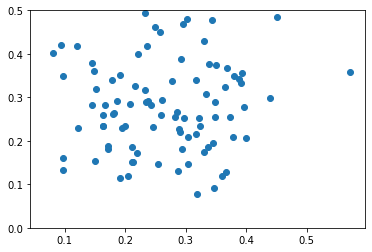

In [10]:
plt.scatter(Y_train[:,0].detach().numpy(), Y_train[:,1].detach().numpy())
plt.ylim(0,0.5)